Import library yang dibutuhkan 

In [1]:
import csv
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,LSTM,SimpleRNN
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from numpy import array
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
from tabulate import tabulate
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['sqrt', 'concatenate', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy



Import Dataset

In [2]:
eth = pd.read_csv('/kaggle/input/ethereum/ETH-USD.csv')

In [3]:
eth.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,11/29/2021,4296.946777,4460.848633,4284.504883,4445.104980,4445.104980,19086475837
1,11/30/2021,4447.768066,4753.266113,4358.074219,4631.479004,4631.479004,28626354111
2,12/1/2021,4623.679688,4780.732422,4530.272461,4586.990234,4586.990234,27634826695
3,12/2/2021,4586.333008,4628.919922,4441.507813,4511.302246,4511.302246,21502671027
4,12/3/2021,4514.355957,4647.289063,4100.145508,4220.706055,4220.706055,25879591528


In [4]:
eth.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
359,11/23/2022,1135.421509,1184.997314,1130.022827,1183.199585,1183.199585,11242676044
360,11/24/2022,1183.345093,1211.627441,1180.379761,1203.983154,1203.983154,9706372376
361,11/25/2022,1203.799438,1203.799438,1174.823364,1198.925903,1198.925903,5483308196
362,11/26/2022,1198.790527,1227.038086,1198.097900,1205.897949,1205.897949,5074160558
363,11/27/2022,1205.905273,1220.349487,1195.039063,1195.126953,1195.126953,4486976868


In [5]:
def plot_series(time, series, format="-", start=0, end=None, Title='Time Series Plot of Ethereum'):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.title(Title)

In [6]:
time_step = []
value = []

with open('/kaggle/input/ethereum/ETH-USD.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    value.append(float(row[4]))
    time_step.append(step)
    step += 1

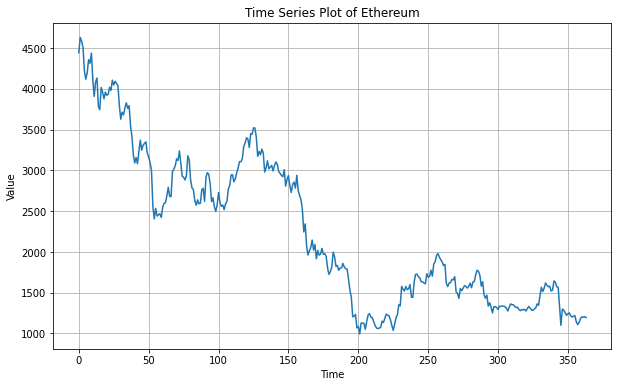

In [7]:
series = np.array(value)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

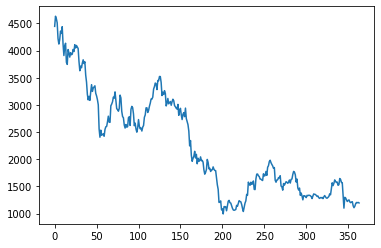

In [8]:
plt.plot(eth['Close'])

In [9]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [10]:
ethereum={'time step':time,'value':series}
df=pd.DataFrame(data=ethereum)
df.head()

,time step,value
0,0,4445.104980
1,1,4631.479004
2,2,4586.990234
3,3,4511.302246
4,4,4220.706055


In [11]:
df=df.set_index("time step")
df.head()

,value
time step,
0,4445.104980
1,4631.479004
2,4586.990234
3,4511.302246
4,4220.706055


In [12]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8619
 No. Lags Chosen       = 4
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.3502. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [13]:
eth_p=eth.filter(['Close'])

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
eth_s = scaler.fit_transform(np.array(eth_p).reshape(-1,1))

In [15]:
training_size = int(len(eth_s)*0.835165)
test_size = len(eth_s) - training_size
training_size,test_size

(304, 60)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



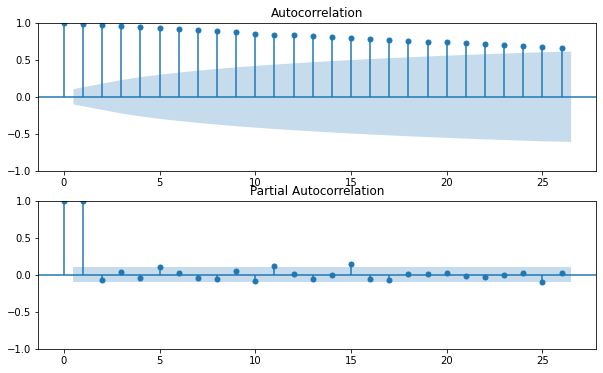

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0]=plot_acf(eth.iloc[:,5],ax=ax[0])
ax[1]=plot_pacf(eth.iloc[:,5],ax=ax[1])

In [17]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX), np.array(dataY)

In [18]:
time_step=1
X_train, Y_train = create_dataset(eth_s[:training_size,:], time_step)
X_test, Y_test = create_dataset(eth_s[training_size-time_step:,:], time_step)

In [19]:
print(X_train.shape), print(Y_train.shape)

(303, 1)
(303,)


(None, None)

In [20]:
#reshape input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

2022-11-30 10:10:11.760894: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


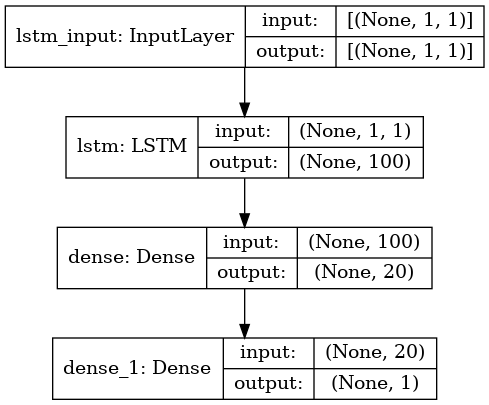

In [21]:
model = Sequential()
model.add(LSTM(100, return_sequences=False, input_shape=(time_step,1)))
#model.add(LSTM(50, return_sequences=False))
model.add(Dense(20,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','mse'])
model.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='LSTM model.png', show_shapes=True)

In [22]:
history = model.fit(X_train, Y_train, epochs=75, verbose=1,batch_size=8,validation_data=(X_test,Y_test) ) 

2022-11-30 10:10:13.173224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
38/38 [==============================] - 2s 14ms/step - loss: 0.1340 - mae: 0.2884 - mse: 0.1340 - val_loss: 0.0111 - val_mae: 0.1004 - val_mse: 0.0111
Epoch 2/75
38/38 [==============================] - 0s 3ms/step - loss: 0.0343 - mae: 0.1561 - mse: 0.0343 - val_loss: 0.0531 - val_mae: 0.2289 - val_mse: 0.0531
Epoch 3/75
38/38 [==============================] - 0s 3ms/step - loss: 0.0215 - mae: 0.1247 - mse: 0.0215 - val_loss: 0.0312 - val_mae: 0.1752 - val_mse: 0.0312
Epoch 4/75
38/38 [==============================] - 0s 4ms/step - loss: 0.0130 - mae: 0.0972 - mse: 0.0130 - val_loss: 0.0183 - val_mae: 0.1338 - val_mse: 0.0183
Epoch 5/75
38/38 [==============================] - 0s 4ms/step - loss: 0.0060 - mae: 0.0661 - mse: 0.0060 - val_loss: 0.0055 - val_mae: 0.0716 - val_mse: 0.0055
Epoch 6/75
38/38 [==============================] - 0s 4ms/step - loss: 0.0018 - mae: 0.0338 - mse: 0.0018 - val_loss: 2.8483e-04 - val_mae: 0.0103 - val_mse: 2.8483e-04
Epoch 7/75
38/38 [=

<Figure size 432x288 with 0 Axes>

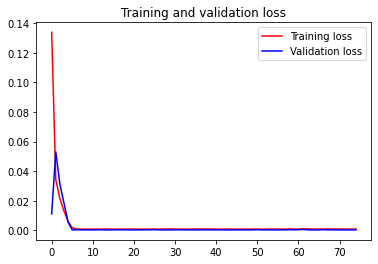

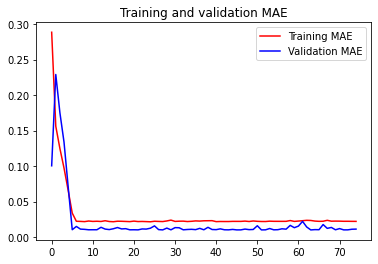

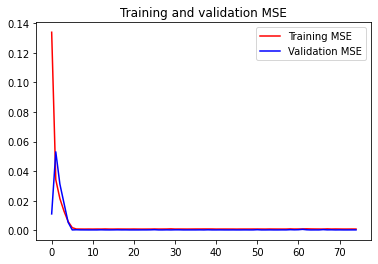

<Figure size 432x288 with 0 Axes>

In [23]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss=history.history['val_loss']
mae=history.history['mae']
val_mae=history.history['val_mae']
mse=history.history['mse']
val_mse=history.history['val_mse']

epochs=range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, mae, 'r', label = 'Training MAE')
plt.plot(epochs, val_mae, 'b', label ='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()
plt.figure()

plt.plot(epochs, mse, 'r', label = 'Training MSE')
plt.plot(epochs, val_mse, 'b', label ='Validation MSE')
plt.title('Training and validation MSE')
plt.legend()
plt.figure()

In [24]:
test_predict = model.predict(X_test)

In [25]:
test_predict_true = scaler.inverse_transform(test_predict.reshape(-1,1))

In [26]:
testY_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

In [27]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = test_predict_true.reshape(len(test_predict_true))

In [28]:
#RMSE
import math
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(np.mean(((test_predict_true- eth_p[training_size:])**2)))
rmse

Close    63.532782
dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



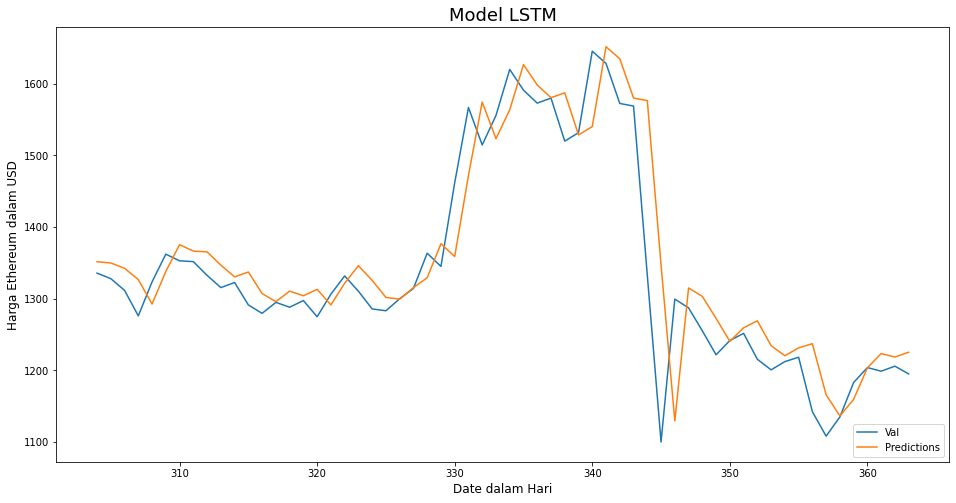

In [29]:
valid = eth[training_size:]
valid['Predictions'] = test_predict_true
plt.figure(figsize=(16,8))
plt.title('Model LSTM', fontsize=18)
plt.xlabel('Date dalam Hari', fontsize=12)
plt.ylabel('Harga Ethereum dalam USD', fontsize=12)
plt.plot(valid[['Close', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [30]:
predictDates = eth.tail(len(X_test)).index

In [31]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])

In [32]:
import numpy as np
dataactual = np.mat(testY_reshape).reshape(1, int(np.prod(np.mat(testY_reshape).shape))).T
datapredict = np.mat(yhat_reshape).reshape(1, int(np.prod(np.mat(yhat_reshape).shape))).T

In [33]:
import pandas as pd
actualtable = pd.DataFrame(dataactual,columns=['Actual Price'])
actualtable
predicttable = pd.DataFrame(datapredict,columns=['Predict Price'])
result = pd.concat([actualtable,predicttable], axis=1, join='inner')
display(result)

,Actual Price,Predict Price
0,1335.652344,1351.513672
1,1327.978638,1349.818481
2,1311.644409,1342.424194
3,1276.093506,1326.698608
4,1323.439209,1292.536377
5,1362.126587,1338.052124
6,1352.837158,1375.360229
7,1351.709473,1366.392456
8,1332.516968,1365.304199
9,1315.500488,1346.796875
